# Анализ работы маркетплейса

## Проблема

Стартап, который недавно запустил маркетплейс столкнулся с проблемой: выручка маркетплейса несколько месяцев стоит на месте. 

###  Цель 
Добиться роста метрик без причинения неудобств клиентам, чтобы не оставить у них негативного опыта.

- Задача 1: Оценить месячный retention в оформление заказа с помощью когортного анализа.
- Задача 2: Определить, существует ли product/market fit у этого маркетплейса.
- Задача 3: Определить 5 основных метрик, на которых продакту можно сконцентрироваться, чтобы максимизировать прибыль компании.
- Задача 4: Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.
- Задача 5: Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.
- Задача 6: Сформулировать выводы о проделанной работе. 

Описание файлов:

### customers— таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя
customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)
customer_zip_code_prefix — почтовый индекс пользователя
customer_city — город доставки пользователя
customer_state — штат доставки пользователя

### orders_dataset —  таблица заказов
order_id — уникальный идентификатор заказа (номер чека)
customer_id — позаказный идентификатор пользователя
order_status — статус заказа
order_purchase_timestamp — время создания заказа
order_approved_at — время подтверждения оплаты заказа
order_delivered_carrier_date — время передачи заказа в логистическую службу
order_delivered_customer_date — время доставки заказа
order_estimated_delivery_date — обещанная дата доставки

### order_items— товарные позиции, входящие в заказы
order_id — уникальный идентификатор заказа (номер чека)
order_item_id — идентификатор товара внутри одного заказа
product_id — ид товара (аналог штрихкода)
seller_id — ид производителя товара
shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике
price — цена за единицу товара
freight_value — вес товара 

Уникальные статусы заказов в таблице olist_orders_dataset:

created — создан;
approved — подтверждён;
invoiced — выставлен счёт;
processing — в процессе сборки заказа;
shipped — отгружён со склада;
delivered — доставлен пользователю;
unavailable — заказ отменён по причине недоступности товара;
canceled — отменён.

In [92]:
import pandas as pd
from operator import attrgetter
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import requests
import urllib

In [93]:
# Установим размер для всех графиков
plt.rcParams['figure.figsize'] = (20, 5)

# Установим параметры сетки для всех графиков
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray' 
plt.rcParams['grid.linestyle'] = '--' 
plt.rcParams['grid.linewidth'] = 0.5 

In [94]:
# считаем файлы с яндекс диска, публичная ссылка на папку и все файлы
link_folder = 'https://disk.yandex.ru/d/UoiisAFUyy5auQ'

file_name_customers = 'olist_customers_dataset.csv'
file_name_orders_dataset = 'olist_orders_dataset.csv'
file_name_order_items = 'olist_order_items_dataset.csv'

In [95]:
# прочитаем файл customers
# формируем URL для получения прямой ссылки
url_customers = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + \
      '?public_key=' + urllib.parse.quote(link_folder) + \
      '&path=/' + urllib.parse.quote(file_name_customers)

# получаем прямую ссылку
response_customers = requests.get(url_customers)
download_url_customers = response_customers.json()['href']

# читаем в датафрейм
customers = pd.read_csv(download_url_customers)

In [96]:
# прочитаем файл orders_dataset
# формируем URL для получения прямой ссылки
url_orders_dataset = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + \
      '?public_key=' + urllib.parse.quote(link_folder) + \
      '&path=/' + urllib.parse.quote(file_name_orders_dataset)

# получаем прямую ссылку
response_orders_dataset = requests.get(url_orders_dataset)
download_url_orders_dataset = response_orders_dataset.json()['href']

# читаем в датафрейм
orders_dataset = pd.read_csv(download_url_orders_dataset, 
                 parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])


In [97]:
# прочитаем файл order_items
# формируем URL для получения прямой ссылки
url_order_items = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + \
      '?public_key=' + urllib.parse.quote(link_folder) + \
      '&path=/' + urllib.parse.quote(file_name_order_items)

# получаем прямую ссылку
response_order_items = requests.get(url_order_items)
download_url_order_items = response_order_items.json()['href']

# читаем в датафрейм
order_items = pd.read_csv(download_url_order_items, 
                         parse_dates=['shipping_limit_date'])


## customers - таблица с уникальными идентификаторами пользователей

In [98]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [99]:
# посмотрим, сколько людей сделало 1 заказ и сколько более 1 заказа, а также долю повторных заказов
count_1_ord = customers.groupby('customer_unique_id',as_index=False)['customer_id'].count().query("customer_id == 1").count()
count_more_1 = customers.groupby('customer_unique_id',as_index=False)['customer_id'].count().query("customer_id > 1").count()
print(count_1_ord.customer_unique_id)
print(count_more_1.customer_unique_id)
print(count_more_1.customer_unique_id / count_1_ord.customer_unique_id)

93099
2997
0.032191538040150805


In [100]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [101]:
customers.shape

(99441, 5)

In [102]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

## orders_dataset —  таблица заказов

In [103]:
orders_dataset.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [104]:
orders_dataset.query("order_id == '00143d0f86d6fbd9f9b38ab440ac16f5'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06


In [105]:
orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [106]:
# посмотрим, какие статусы заказов имеются в данных
orders_dataset.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [107]:
orders_dataset.shape

(99441, 8)

In [108]:
orders_dataset.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [109]:
# Так как данные с пропусками могут помешать некоторым исследованиям, создадим копию датафрейма без пропущенных значений
orders = orders_dataset.copy()
orders.dropna(subset=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'], inplace=True)

## order_items — товарные позиции, входящие в заказы

In [110]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [111]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [112]:
order_items.shape

(112650, 7)

In [113]:
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

# Задача 1. Оценить месячный retention в оформление заказа с помощью когортного анализа.

В рамках исследования решим следующие задачи:

Исследовать датасет и определить, какой вид заказа будет учитываться в retention.
Построить месячный retention.
Проанализировать, чему равен медианный retention 1-го месяца.
Найти когорту с самым высоким retention на 3-й месяц..

### Проведем исследование данных для решения первой задачи

In [114]:
# объединим customers и orders для выявления связи между уникальным пользователем и количеством заказов
cust_ord = pd.merge(customers, orders, on='customer_id', how='inner')
# получим единый датафрейм для всех данных
full_df = pd.merge(cust_ord, order_items, on='order_id', how='inner')

In [115]:
cust_ord.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


In [116]:
# посмотрим структуру данных
cust_ord.query("order_id == '00143d0f86d6fbd9f9b38ab440ac16f5'")

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
56518,2e45292979b9b2700ea09560eeb0f803,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO,00143d0f86d6fbd9f9b38ab440ac16f5,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06


In [117]:
# посмотрим сколько минимально и сколько максимально заказывают люди
cust_ord.groupby('customer_unique_id').agg({'order_id':'count'}).sort_values('order_id')

,order_id
customer_unique_id,
fffea47cd6d3cc0a88bd621562a9d061,1
00172711b30d52eea8b313a7f2cced02,1
00191a9719ef48ebb5860b130347bf33,1
001926cef41060fae572e2e7b30bd2a4,1
001928b561575b2821c92254a2327d06,1
...,...
1b6c7548a2a1f9037c1fd3ddfed95f33,7
6469f99c1f9dfae7733b25662e7f1782,7
ca77025e7201e3b30c44b472ff346268,7


In [118]:
#отфильтруем заказы с нужным статусом processing, shipped, delivered, unavailable
df_retention = cust_ord.query("order_status == ['processing', 'shipped', 'delivered', 'unavailable']")

### Проведем когортный анализ

In [119]:
df_ret = df_retention.copy()

In [120]:
# Извлечем месяц и день заказа
df_ret['month_ord'] = df_ret['order_approved_at'].dt.to_period('M')
df_ret['day_ord'] = df_ret['order_approved_at'].dt.to_period('D')

In [121]:
# Присвоим когорты на основе даты первого действия для каждого пользователя
df_ret['month_cohort'] = df_ret.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('M')
df_ret['day_cohort'] = df_ret.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('D')

In [122]:
# Рассчитаем номер периода в днях (месячные периоды, деля на 30)
df_ret['period_number_month'] = np.floor((df_ret.day_ord - df_ret.day_cohort).apply(attrgetter('n')) / 30)

In [123]:
# проверим, что периоды верно присвоились
#cust_ord.query("customer_unique_id == 'ca77025e7201e3b30c44b472ff346268'")

In [124]:
df_ret.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_ord,day_ord,month_cohort,day_cohort,period_number_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05-16,2017-05,2017-05-16,0.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,2018-01-12,2018-01,2018-01-12,0.0


In [125]:
# Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = df_ret.groupby(['month_cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

In [126]:
df_cohort.head()

,month_cohort,period_number_month,n_customers
0,2016-09,0.0,1
1,2016-10,0.0,262
2,2016-10,6.0,1
3,2016-10,9.0,1
4,2016-10,11.0,1


In [127]:
# Создадим сводную таблицу для когортного анализа
cohort_pivot = df_cohort.pivot_table(index='month_cohort', columns='period_number_month', values='n_customers')
cohort_pivot

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
month_cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,683.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1612.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,1.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN
2017-03,2511.0,7.0,12.0,11.0,3.0,2.0,8.0,5.0,6.0,6.0,...,4.0,4.0,3.0,6.0,3.0,3.0,2.0,NaN,NaN,NaN
2017-04,2232.0,8.0,6.0,NaN,6.0,8.0,6.0,10.0,5.0,5.0,...,3.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
2017-05,3452.0,14.0,14.0,9.0,13.0,11.0,11.0,5.0,11.0,9.0,...,10.0,6.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3044.0,13.0,15.0,11.0,5.0,16.0,8.0,6.0,4.0,9.0,...,10.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# Рассчиттаем размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [129]:
# Вычислим коэффициенты удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
month_cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002928,NaN,0.005857,0.001464,0.001464,0.002928,0.002928,NaN,NaN,...,0.005857,0.004392,0.002928,NaN,0.002928,0.002928,0.002928,0.001464,NaN,NaN
2017-02,1.0,0.001241,0.001861,0.003722,0.002481,0.001241,0.002481,0.000620,0.000620,0.002481,...,0.003722,0.000620,0.001861,0.001241,0.000620,0.000620,0.001861,NaN,NaN,NaN
2017-03,1.0,0.002788,0.004779,0.004381,0.001195,0.000796,0.003186,0.001991,0.002389,0.002389,...,0.001593,0.001593,0.001195,0.002389,0.001195,0.001195,0.000796,NaN,NaN,NaN
2017-04,1.0,0.003584,0.002688,NaN,0.002688,0.003584,0.002688,0.004480,0.002240,0.002240,...,0.001344,NaN,0.000896,0.000896,0.000896,0.000896,NaN,NaN,NaN,NaN
2017-05,1.0,0.004056,0.004056,0.002607,0.003766,0.003187,0.003187,0.001448,0.003187,0.002607,...,0.002897,0.001738,0.000869,0.002028,0.001159,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,0.004271,0.004928,0.003614,0.001643,0.005256,0.002628,0.001971,0.001314,0.002957,...,0.003285,0.000986,0.002957,0.001314,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
# определим медианный retention 1-го месяца
retention_matrix[1.0].median()

0.00350498786734969

## Выводы по задаче 1
1. Для расчета метрики retention нас интересуют заказы со статусом (order_status): processing, shipped, delivered, unavailable, так как только эти статусы заказа отражают тот факт, что клиент оплатил заказ.
2. Расчеты показали, что медианный retention 1-го месяца равен 0.0035, что говорит об отсутствии удержания клиентов в продукте.
3. Самый высокий retention на 3-ий месяц имеет когорта 2017-01, он равен 0.0058.

# Задача 2. Определить, существует ли product/market fit у маркетплейса.

Оценим, насколько хорошо продукт закрывает потребности клиента, для этого определим, существует ли product/market fit у этого маркетплейса для принятия решения о масштабировании. Есть вероятность, что маркетплейс будет приносить убытки.

В рамках исследования решим следующие задачи:

Оценить наличие product/market fit у данного продукта с помощью когортного анализа, полученного на предыдущем шаге.
Пояснить свою позицию и сформулировать, на чём маркетплейс должен сконцентрироваться в ближайшее время. Если PMF есть, то в какую сторону лучше развивать продукт дальше? Если PMF нет, то какие причины могут быть у этого?

In [131]:
# Количество уникальных товаров, заказанных на платформе
order_items.product_id.nunique()

32951

In [132]:
# процент отменненных заказов по причине недоступности товара;
orders_dataset.query("order_status == 'unavailable'").order_id.nunique()*100 / orders_dataset.order_id.nunique()

0.6124234470691163

In [133]:
# процент отмененных заказов
orders_dataset.query("order_status == 'canceled'").order_id.nunique()*100 / orders_dataset.order_id.nunique()

0.6285133898492573

In [134]:
# создадим копию датафрейма и удалим строки с пустыми значениями
delivery_time = orders_dataset.copy()
delivery_time.dropna(subset=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'], inplace=True)

In [135]:
# рассчитаем время разных этапов заказа

# сколько времени до подтверждения заказа
delivery_time['time_approved'] = delivery_time.order_approved_at - delivery_time.order_purchase_timestamp
# сколько времени в среднем передают в логистическую службу
delivery_time['time_carrier'] = delivery_time.order_delivered_carrier_date - delivery_time.order_approved_at
# сколько в среднем доставляется заказ логистической компанией
delivery_time['time_delivered_customer'] = delivery_time.order_delivered_customer_date - delivery_time.order_delivered_carrier_date
# сколько в среднем доставляется заказ суммарно
delivery_time['time_all_delivered'] = delivery_time.order_delivered_customer_date - delivery_time.order_approved_at
# есть ли разница между обещанным сроком доставки и фактическим
delivery_time['time_estimated'] = delivery_time.order_estimated_delivery_date - delivery_time.order_delivered_customer_date

In [136]:
#сколько времени до подтверждения заказа
delivery_time.time_approved.describe()

count                        96461
mean     0 days 10:16:39.837893034
std      0 days 20:32:08.144063780
min                0 days 00:00:00
25%                0 days 00:12:55
50%                0 days 00:20:36
75%                0 days 14:31:05
max               30 days 21:26:37
Name: time_approved, dtype: object

In [137]:
#сколько времени в среднем передают в логистическую службу
delivery_time.time_carrier.describe()

count                        96461
mean     2 days 19:10:58.028685168
std      3 days 12:54:06.348358820
min            -172 days +18:44:38
25%                0 days 20:59:05
50%                1 days 19:34:50
75%                3 days 13:48:18
max              125 days 18:18:06
Name: time_carrier, dtype: object

В данном случае видно, что минимальный срок передачи заказа в логистическую компанию составляет -172 дня, что указывает на ошибку в данных, посмотрим, как много ошибок в данных:

In [138]:
# посмотреть подробно проблему ошибок в записях
#delivery_time.sort_values('time_carrier', ascending=True).head()

In [139]:
# смотрим количество записей с ошибками
delivery_time_01 = delivery_time.query("order_delivered_carrier_date < order_approved_at").order_id.count()
print(f"Количество записей, когда товар был передан в логистическую службу раньше, чем получено подтверждение оплаты: {delivery_time_01:.0f}")

delivery_time_02 = delivery_time.query("order_delivered_carrier_date < order_purchase_timestamp").order_id.count()
print(f"Количество записей, когда товар был передан в логистическую службу раньше, чем оформлен: {delivery_time_02:.0f}")

delivery_time_03 = delivery_time.query("order_delivered_customer_date < order_delivered_carrier_date").order_id.count()
print(f"Количество записей, когда логистическая компания доставила заказ раньше, чем получила: {delivery_time_03:.0f}")

Количество записей, когда товар был передан в логистическую службу раньше, чем получено подтверждение оплаты: 1350
Количество записей, когда товар был передан в логистическую службу раньше, чем оформлен: 165
Количество записей, когда логистическая компания доставила заказ раньше, чем получила: 23


Учитывая, что общее количество записей почти 100 тысяч, для оценки средних значений времени доставки исключим некорректные записи из датасета

In [140]:
# сколько времени в среднем передают в логистическую службу
# исключаем отрицательные значения и выводим описательную статистику
delivery_time_1 = delivery_time.query("order_delivered_carrier_date > order_approved_at")
delivery_time_1.time_carrier.describe()

count                        95111
mean     2 days 20:29:13.224579701
std      3 days 11:39:43.879789556
min                0 days 00:00:15
25%                0 days 21:36:50
50%                1 days 20:22:51
75%                3 days 14:51:25
max              125 days 18:18:06
Name: time_carrier, dtype: object

In [141]:
# сколько в среднем доставляется заказ логистической компанией
# исключаем отрицательные значения и выводим описательную статистику
delivery_time_2 = delivery_time.query("order_delivered_customer_date > order_delivered_carrier_date")
delivery_time_2.time_delivered_customer.describe()

count                        96429
mean     9 days 08:01:43.613176533
std      8 days 18:13:27.772741923
min                0 days 00:00:01
25%                4 days 02:27:31
50%                7 days 02:24:37
75%               12 days 00:44:55
max              205 days 04:35:00
Name: time_delivered_customer, dtype: object

In [142]:
# сколько в среднем доставляется заказ суммарно
# исключаем отрицательные значения и выводим описательную статистику
delivery_time_3 = delivery_time.query("order_delivered_customer_date > order_approved_at")
delivery_time_3.time_all_delivered.describe()

count                         96400
mean     12 days 03:19:38.884678423
std       9 days 12:18:11.756795673
min                 0 days 00:11:02
25%          6 days 07:33:24.500000
50%                 9 days 20:34:24
75%         15 days 03:28:40.500000
max               208 days 12:01:24
Name: time_all_delivered, dtype: object

In [143]:
# есть ли разница между обещанным сроком и фактическим
delivery_time.time_estimated.describe()

count                         96461
mean     11 days 04:16:01.007909932
std      10 days 04:27:25.366427548
min             -189 days +00:35:53
25%                 6 days 09:20:35
50%                11 days 22:41:24
75%                16 days 05:51:07
max               146 days 00:23:13
Name: time_estimated, dtype: object

In [144]:
# сколько заказов доставлено позже обещанного срока
res_late = delivery_time[delivery_time['time_estimated'] < pd.Timedelta(0)].order_id.nunique()
res_late

7826

In [145]:
# сколько заказов доставлено позже обещанного срока в долях от общего
res_late / delivery_time.order_id.nunique()

0.08113123438488094

In [146]:
# сколько суммарно было получено дохода
full_df.price.sum().round()

np.float64(13219046.0)

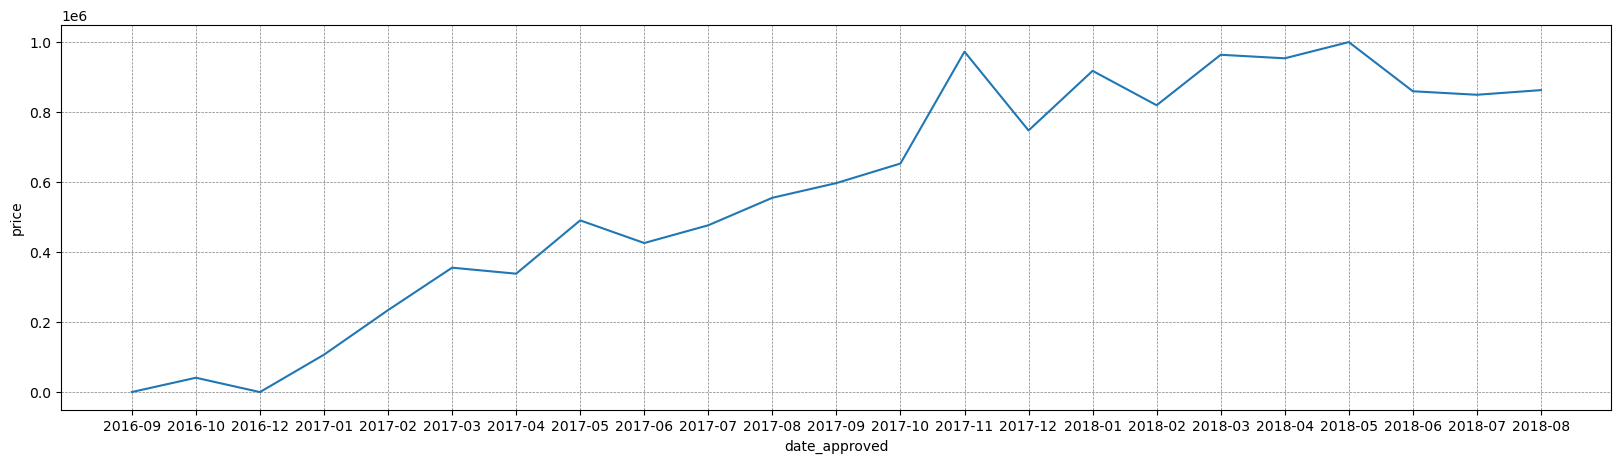

In [147]:
# доход по месяцам
full_df['date_approved'] = full_df['order_approved_at'].dt.strftime('%Y-%m')
revenue = full_df.groupby('date_approved', as_index=False).agg({'price':'sum'})
sns.lineplot(x="date_approved", y="price", data=revenue)
plt.show()

In [148]:
# описательная статистика по доходу от заказов
full_df.groupby('order_id').agg({'price':'sum'}).describe()

,price
count,96461.000000
mean,137.040313
std,209.059760
min,0.850000
25%,45.900000
50%,86.500000
75%,149.900000
max,13440.000000


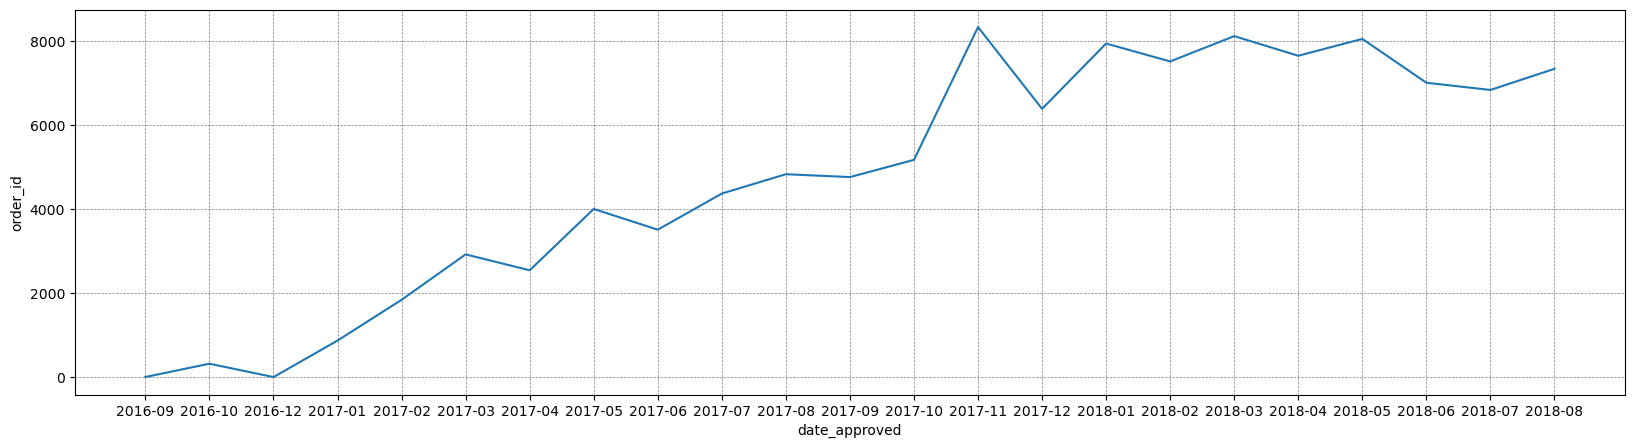

In [149]:
# количество заказов по месяцам
cnt_ord = full_df.groupby('date_approved', as_index=False).agg({'order_id':'count'})
sns.lineplot(x="date_approved", y="order_id", data=cnt_ord)
plt.show()

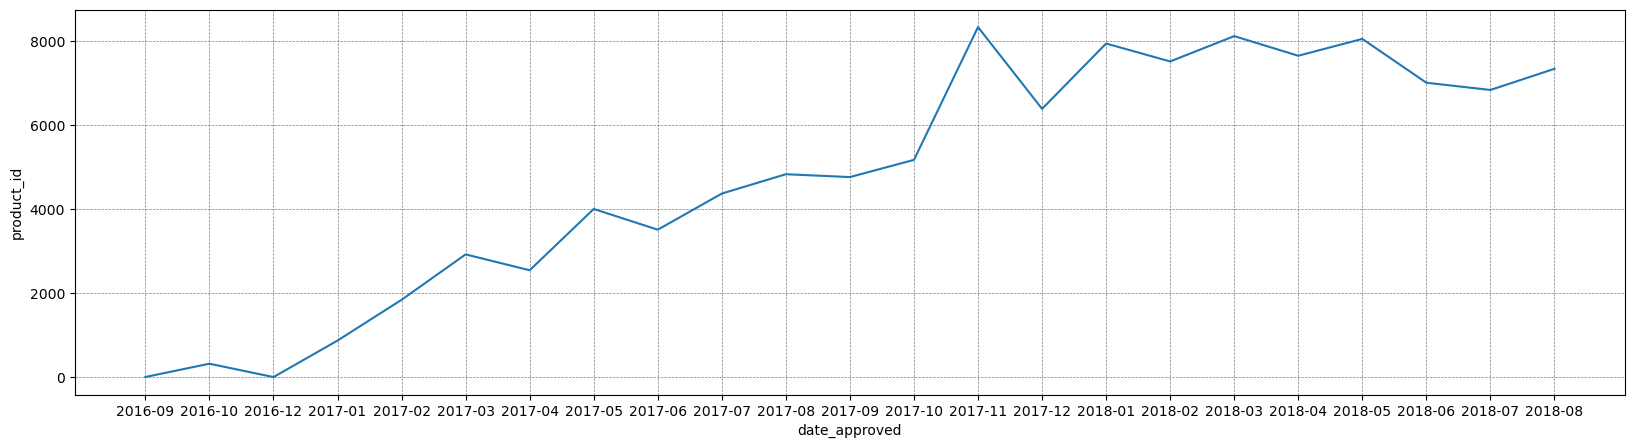

In [150]:
# количество товаров по месяцам
cnt_prod = full_df.groupby('date_approved', as_index=False).agg({'product_id':'count'})
sns.lineplot(x="date_approved", y="product_id", data=cnt_prod)
plt.show()

## Выводы по задаче 2
У данного продукта отсутствует product/market fit, что показывают данные:не происходит удержание клиентов, retention меньше 1 процента. В первую очередь маркетплейсу необходимо сконцентрироваться на повышении retention: подробнее изучить клиентов и их потребности.

Анализ данных показал, что самым слабым местом маркетплейса являеются сроки доставок заказов. Несмотря на то, что реальный срок доставки в среднем на 11 дней меньше обещанного, среднее время доставки товара 9 дней, а каждый 4 клиент ожидает товар более 2 недель. В дополнение почти 10 процентов клиентов получают заказ позже обещанного срока, что также отрицательно влияет на PMF.
Можно предположить, что в настоящее время у клиентов есть возможность получить заказ быстрее, поэтому они уходят на другие площадки. 

Причем сам маркетплейс оперативно передает товары логистической компании и основной срок доставки приходится именно на нее. Можно попробовать воспользоваться услугами другой логистической компании.

Также можно принять во внимание время от оформления до подтверждения заказа. Четверть клиентов подтверждают заказ спустя более чем 14 часов после оформления. Если направить маркетинг на данную аудиторию, можно уменьшить это время, дав возможность клиенту осознать ценность продукта.

Исследованы также другие факторы, которые не влияют или влияют незначительно на retention:
- ассортимент, он достаточно большой почти 33 тысячи, из этого можно предположить, что отсутствие PMF не связано с небольшим ассортиментом товаровно для уверенности можно изучить ассортимент конкурентов;
- отмена заказов, доля всех отмененных заказов слишком мала, около 1 процента от всех заказов, поэтому не может значительно изменить PMF


Анализ дохода маркетплейса показал что последние 3 месяца действительно показывают доходность ниже, чем в предыдущие месяцы, но подобный тренд можно обнаружить и годом ранее, когда доход июня был меньше, чем в мае. Вероятно это связано с сезонностью, клиенты могут летом находиться в отпуске не дома, поэтому меньше покупать товаров.

# Задача 3. Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

Определим 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

Первая метрика должна отражать рост объёма продаж маркетплейса.
Вторая — показывать объем аудитории, которой продукт доставляет ценность.
Третья — отражать заинтересованность новых клиентов в продукте.
Четвёртая — отражать вовлеченность клиента в продолжение использования продукта.
Пятая — отражать денежное выражение вовлеченности клиента.

В качестве первой метрики, с помощью которой можно отслеживать рост объёма продаж маркетплейса, используем доход маркетплейса в месяц.

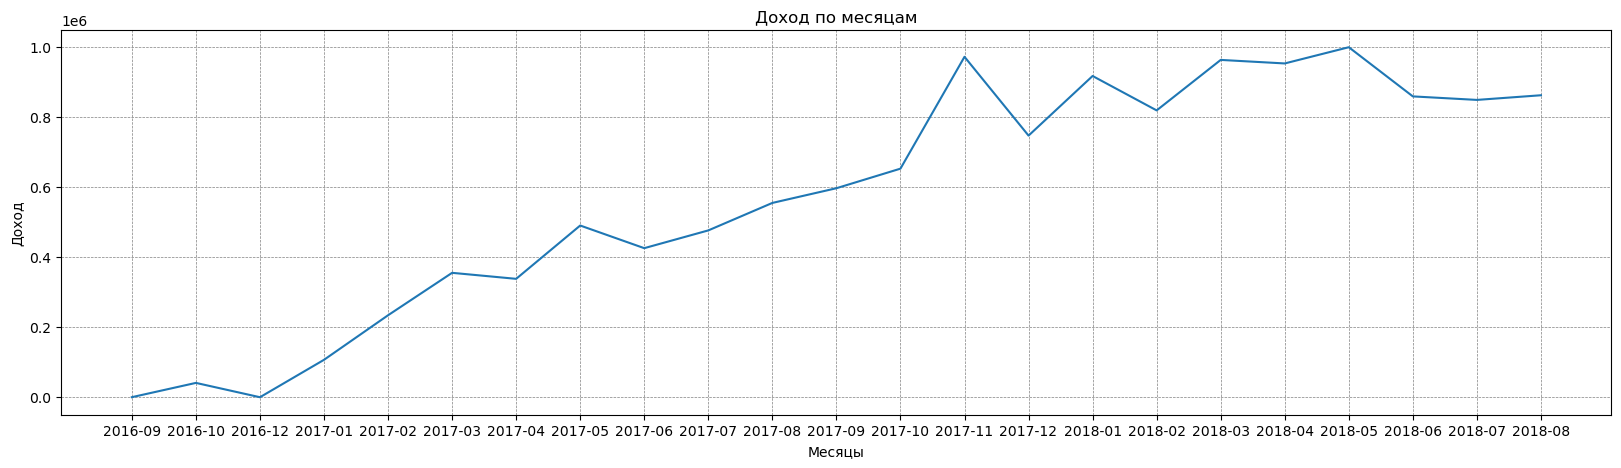

In [151]:
# доход по месяцам
revenue = full_df.groupby('date_approved', as_index=False).agg(revenue=('price','sum'))
sns.lineplot(x="date_approved", y="revenue", data=revenue)

plt.title('Доход по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Доход')
# plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

В качестве второй метрики, которая будет показывать объем аудитории, которой продукт доставляет ценность, будем рассчитывать долю аудитории, которые сделали больше 2 заказов.
Предполагаем, если клиент сделал два заказа, его все устроило и он сделал третий заказ, то он осознает ценность продукта.

In [152]:
# Посмотрим описательную статистику по тому, сколько заказов делают клиенты
order_cnt_cust =cust_ord.groupby('customer_unique_id', as_index=False).agg({'order_id':'nunique'})
order_cnt_cust.describe()

,order_id
count,93342.000000
mean,1.033415
std,0.209091
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,15.000000


In [153]:
# посмотрим, сколько было клиентов с покупками больше 2
cast_value = order_cnt_cust.groupby('order_id', as_index= False).agg({'customer_unique_id':'count'}).query("order_id > 2")
cast_value

,order_id,customer_unique_id
2,3,181
3,4,28
4,5,9
5,6,5
6,7,3
7,9,1
8,15,1


In [154]:
# посчитаем количество клиентов, которые сделали больше 1-2 заказа и больше 2 заказов
loyal = order_cnt_cust.groupby('order_id', as_index= False).agg({'customer_unique_id':'count'}).query("order_id > 1").customer_unique_id.sum()
not_loyal = order_cnt_cust.groupby('order_id', as_index= False).agg({'customer_unique_id':'count'}).query("order_id <= 1").customer_unique_id.sum()

# объединим данные в датасет для графического отображения
loyal_customer = {
    'лояльность': ['Лояльные', 'Нелояльные'],
    'количество': [loyal, not_loyal] }
df_loyal_customer = pd.DataFrame(loyal_customer)

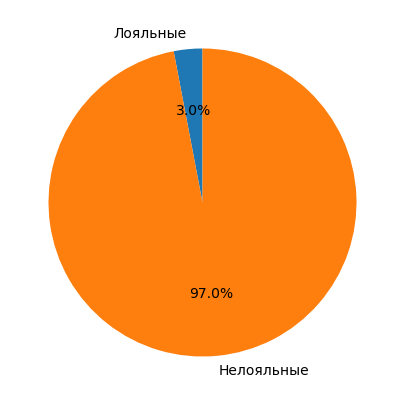

In [155]:
# Посмотрим долю лояльных пользователей на круговой диаграмме
plt.pie(df_loyal_customer['количество'], labels=df_loyal_customer['лояльность'], autopct='%1.1f%%', startangle=90)
plt.show()

В качестве третьей метрики, которая будет отражать заинтересованность новых клиентов в продукте, будем использовать MAU - число уникальных активных пользователей за месяц.

In [156]:
# количество уникальных пользователей за месяц
cnt_unique_cust = full_df.groupby('date_approved', as_index=False).agg({'customer_unique_id':'count'})
# sns.lineplot(x="date_approved", y="customer_unique_id", data=cnt_unique_cust)
# plt.show()

В качестве четвертой метрики, которая будет отражать вовлеченность клиента в продолжение использования продукта, используем retention.

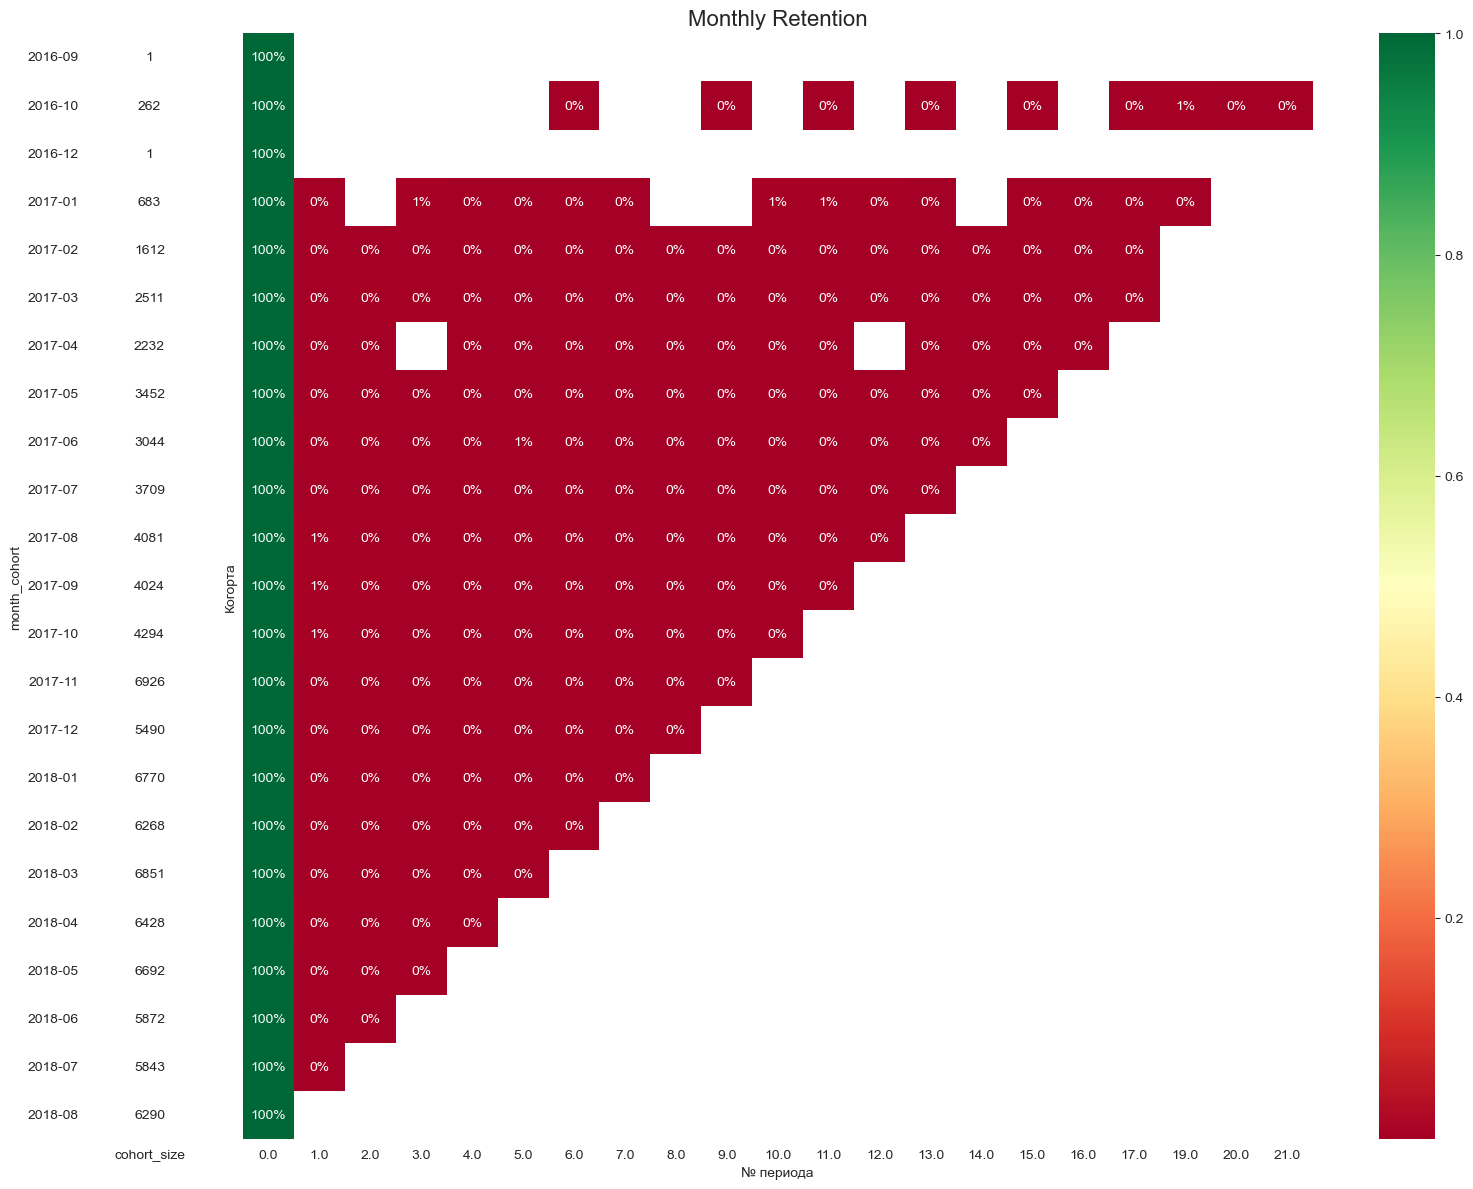

In [157]:
# Построим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

В качестве пятой метрики, которая будет отражать денежное выражение вовлеченности клиента, используем ARPPU - среднюю выручку на платящего пользователя.

In [158]:
# подготовим данные для отображения ARPPU по месяцам

# рассчитаем сумму каждого заказа клиента
sum_gds = full_df.groupby(['date_approved', 'customer_unique_id', 'order_id'], as_index=False).agg({'price':'sum'})
# рассчитаем среднюю стоимость заказа для каждого клиента
mean_cust = sum_gds.groupby(['date_approved', 'customer_unique_id'], as_index=False).agg({'price':'mean'})
# рассчитаем среднюю стоимость заказа по месяцам
arppu_month = mean_cust.groupby('date_approved', as_index=False).agg({'price':'mean'})

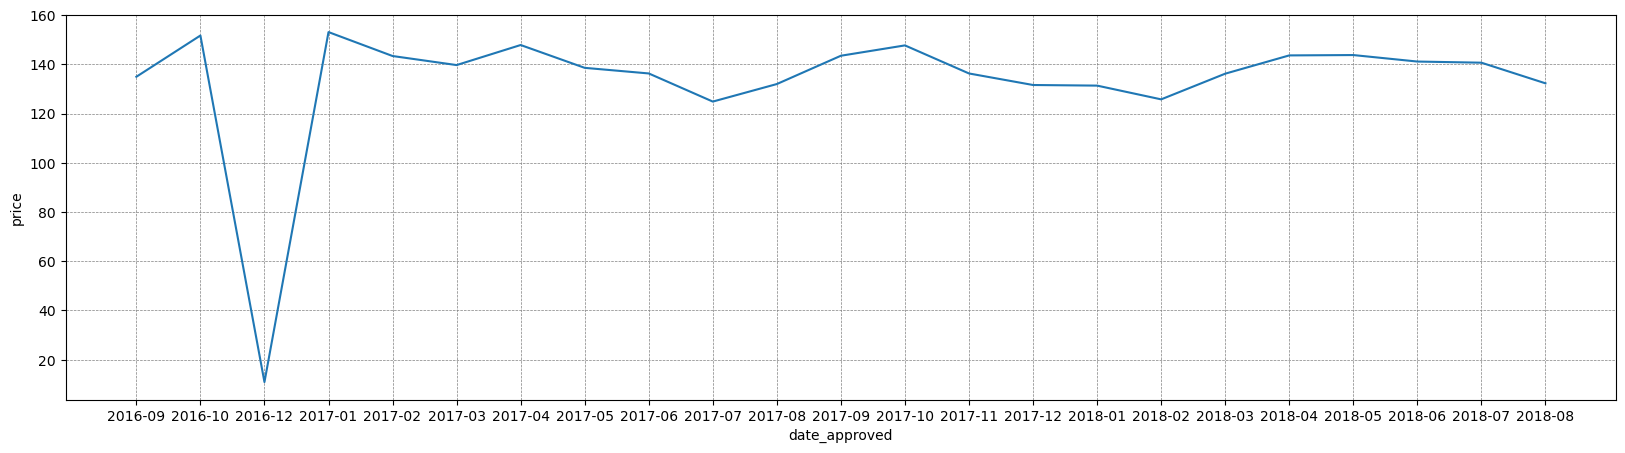

In [159]:
sns.lineplot(x="date_approved", y="price", data=arppu_month)
plt.show()

# Выводы по задаче 3

Сконцентрируемся на следующих метриках для максимизации прибыли компании:

- в качестве первой метрики, с помощью которой можно отслеживать рост объёма продаж маркетплейса, используем доход маркетплейса в месяц;
- в качестве второй метрики, которая будет показывать объем аудитории, которой продукт доставляет ценность, будем рассчитывать долю аудитории, которые сделали больше 2 заказов;
- в качестве третьей метрики, которая будет отражать заинтересованность новых клиентов в продукте, будем использовать MAU - число уникальных активных пользователей за месяц;
- в качестве четвертой метрики, которая будет отражать вовлеченность клиента в продолжение использования продукта, используем retention;
- в качестве пятой метрики, которая будет отражать денежное выражение вовлеченности клиента, используем ARPPU - среднюю выручку на платящего пользователя.

# Задача 4. Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

Вместе с командой были сформулировали 3 гипотезы. Проверим эти гипотезы с помощью фреймворка ICE.

In [160]:
# команда заполнила показатели по Ease, Confidence
confidence_1 = 8
confidence_2 = 10
confidence_3 = 5

ease_1 = 6
ease_2 = 4
ease_3 = 9

In [161]:
# предобработаем данные, добавим столбец с месяцем
orders_dataset['month_ord'] = orders_dataset['order_approved_at'].dt.to_period('M')

In [162]:
# посмотрим количество доставленных заказов с июня 2017 
orders_dataset.loc[(orders_dataset['month_ord'] >= '2017-06') & (orders_dataset['order_status'] == 'delivered')].order_id.nunique()

85464

### Гипотеза 1
Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

Для этого посчитаем количество отмененных заказов. Считаем только заказы со статусом unavailable (отменено по причине недоступности товара), так как система может заранее проверить наличие товара на складе, тогда как статус canceled скорее всего связан с личными причинами отмен заказов клиентами и на него повлиять исправление бага не сможет.

In [163]:
# рассчитаем количество отмененных заказов в июне 2017 
impact_hypothesis_1 = orders_dataset.loc[
    (orders_dataset['month_ord'] >= '2017-06') & 
    (orders_dataset['order_status'].isin(['unavailable']))
].order_id.nunique()

print(f"Количество отмененных заказов в июне 2017: {impact_hypothesis_1:.0f}")

Количество отмененных заказов в июне 2017: 475


### Гипотеза 2
Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. 

Посчитаем количество заказов доставленных позже обещанного срока и умножим на retention первого месяца

In [165]:
# рассчитаем, на сколько заказов мы сможем увеличить продажи
gip_2 = res_late * 0.0035
print(f"Гипотеза 2 позволит увеличить продажи на {gip_2:.0f} заказов")

Гипотеза 2 позволит увеличить продажи на 27 заказов


### Гипотеза 3
Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

Посчитаем количество созданных, но не подтвержденных заказов.

In [166]:
# количество неподтвержденных заказов в июне 2017
impact_hypothesis_3 = orders_dataset.loc[
    (orders_dataset['order_purchase_timestamp'] >= '2017-06-01') & 
    (orders_dataset['order_status'].isin(['created']))
].order_id.nunique()

gip_3 = impact_hypothesis_3 + impact_hypothesis_3 * 0.0035
print(f"Количество неподтвержденных заказов в июне 2017: {gip_3:.0f}")

Количество неподтвержденных заказов в июне 2017: 5


In [167]:
# переведем полученные метрики в значение impact с помощью имеющейся шкалы перевода
impact_1 = 4
impact_2 = 1
impact_3 = 1

In [168]:
# рассчитаем фреймворк ICE для каждой гипотезы
ICE_1 = impact_1 * confidence_1 * ease_1
ICE_2 = impact_2 * confidence_2 * ease_2
ICE_3 = impact_3 * confidence_3 * ease_3

print(f"ICE гипотезы 1 = {ICE_1:.0f}")
print(f"ICE гипотезы 2 = {ICE_2:.0f}")
print(f"ICE гипотезы 3 = {ICE_3:.0f}")

ICE гипотезы 1 = 192
ICE гипотезы 2 = 40
ICE гипотезы 3 = 45


# Выводы по задаче 4
Проведя анализ данных по фреймфорку ICE была выбрана первая гипотеза об исправлении бага в системе процессинга заказов.

# Задача 5. Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

После предыдущего исследования у вас появилась гипотеза, которую можно реализовать для значительного улучшения метрик компании. Вы предложили использовать A/B-тестирование для проверки её эффективности.

Продакт попросил вас:

Сформулировать метрики, на которые должна повлиять выбранная вами гипотеза.
Сформулировать хотя бы по одной метрике в категории: целевые, прокси, guardrail.

# Выводы по задаче 5

При проведении A/B-тестирования гипотезы об избавлении отмен заказов в результате исправления бага в системе процессинга заказов рекомендуется отслеживать следующие метрики:
    
- целевыми метриками являются доход в месяц и ARPPU;

- прокси метриками являются доля клиентов, которые сделали больше 2 заказов и месячный retention;

- барьерной метрикой выступает MAU.


# Общие выводы по итогу исследования

В процессе работы были проанализированы данные за последние два года работы маркетплейса и выяснено следующее.

1. Были обнаружены ошибки в заполнении данных: часть записей, касающихся дат операций не соответствовала друг другу.

2. Основная проблема отсутствие роста выручки в течение нескольких месяцев, с которой продакт-менеджер обратился за помощью с анализом данных маркетплейса, вероятнее всего является следствием сезонности действий клиентов, так как тренд совпадает с прошлым годом, а также, как оказалось, она не является основной проблемой для продукта.

3. В целом анализ доходности маркетплейса показал, что первый год работы был успешнее второго. Темпы роста дохода снизились примерно в три раза, прослеживается тенденция к стагнации дохода, вероятно это связано с тем, что товары новые, в начале они вызвали интерес у клиентов, который со временем пропадает.

4. Основная проблема продукта - низкий retention менее 1 процента. За все время работы маркетплейса лишь 3% клиентов сделали 3 и более заказов. У продукта отсутствует product/market fit. В первую очередь маркетплейсу необходимо сконцентрироваться на повышении retention: подробнее изучить клиентов и их потребности.

5. Анализ данных показал, что самым слабым местом маркетплейса являеются сроки доставок заказов. Несмотря на то, что реальный срок доставки в среднем на 11 дней меньше обещанного, среднее время доставки товара 9 дней, а каждый 4 клиент ожидает товар более 2 недель. В дополнение почти 10 процентов клиентов получают заказ позже обещанного срока, что также отрицательно влияет на PMF.
Можно предположить, что в настоящее время у клиентов есть возможность получить заказ быстрее, поэтому они уходят на другие площадки. 

6. Также необходимо принять во внимание время от оформления до подтверждения заказа. Четверть клиентов подтверждают заказ спустя более чем 14 часов после оформления. 

# Рекомендации по продукту

1. Чтобы максимизировать прибыль компании рекомендуется продакту сконцентрироваться на основных метриках: целевых - месячному доходу и ARPPU, прокси - месячный retention и доле клиентов, которые сделали больше 2 заказов и барьерной MAU.

2. Провести A/B-тестирование гипотезы об избавлении отмен заказов в результате исправления бага в системе процессинга заказов и оценить, повлияет ли она на основные метрики.

3. Также можно провести анализ других логистических компаний и при наличии компании, которая доставляться заказы в меньшие сроки, чем текущая, воспользоваться ее услугами.

4. Провести маркетинговую компанию, нацеленную на клиентов, которые не закончили оформление заказа.
Если направить маркетинг на данную аудиторию, можно уменьшить это время, дав возможность клиенту понять ценность продукта.

5. Провести анализ товаров, подумать над расширением ассортимента другими категориями товаров.

6. Рекомендуется обратить внимание на причины возникновения ошибок в данных, так как в дальнейшем это может усложнить анализ работы компании.

7. Провести опрос клиентов после получения заказа для оценки удовлетворенности заказом и определения проблемных зон взаимодействия клиентов с продуктом.



Проект выполнен в рамках прохождения курса "Аналитик данных" от KarpovCourses